In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
np.random.seed(1907)

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("The data size:", df.shape)

## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

df= df.drop('customerID', axis = 1)

df.head()

The data size: (7043, 21)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [2]:
df = pd.get_dummies(df)
print("The data size:", df.shape)

labels = np.array(df['Churn'])
df= df.drop('Churn', axis = 1)

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.2, random_state = 42)


The data size: (7043, 46)


In [3]:
rfc = RandomForestClassifier(n_estimators=100, max_features=7)

rfc = rfc.fit(train_x,train_y)

#Predict the response for test dataset
y_pred3 = rfc.predict(test_x)
y_pred_prob = rfc.predict_proba(test_x)[:,1]

print(confusion_matrix(test_y, y_pred3))
print("Accuracy:",metrics.accuracy_score(test_y, y_pred3))
# print ("AUC Score:", roc_auc_score(test_y, y_pred3))
# print ("AUC Score prob:", roc_auc_score(test_y, y_pred_prob))
# print ("Precision:", precision_score(test_y, y_pred3))
# print ("Recall:", recall_score(test_y, y_pred3))
print ("F1 Score:", f1_score(test_y, y_pred3))

# feature_importances = pd.DataFrame(rfc.feature_importances_,
#                                   index = train_x.columns,
#                                    columns=['importance']).sort_values('importance', ascending=False)

# print(feature_importances)

[[944  92]
 [196 177]]
Accuracy: 0.7955997161107168
F1 Score: 0.5514018691588786


In [4]:
scaler = MinMaxScaler(feature_range= (0,1))

scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [5]:
svm1 = svm.SVC(verbose=True)
svm1.fit(train_x,train_y)

y_pred = svm1.predict(test_x)

#y_pred_prob = svm1.predict_proba(test_x)[:,1]

print(confusion_matrix(test_y, y_pred))
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
# print ("AUC Score:", roc_auc_score(test_y, y_pred))
# print ("AUC Score prob:", roc_auc_score(test_y, y_pred_prob))
# print ("Precision:", precision_score(test_y, y_pred))
# print ("Recall:", recall_score(test_y, y_pred))
print ("F1 Score:", f1_score(test_y, y_pred))

[LibSVM][[946  90]
 [177 196]]
Accuracy: 0.8105039034776437
F1 Score: 0.5948406676783005


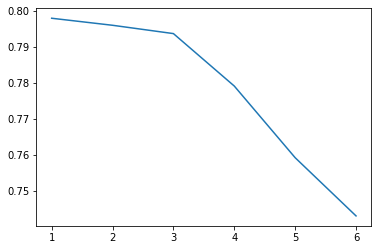

In [6]:
from sklearn.model_selection import cross_val_score
degree_range=[1,2,3,4,5,6]
accuracy=[]
for degree_val in degree_range:
    svc = svm.SVC(kernel='poly', degree=degree_val)
    scores = cross_val_score(svc, train_x, train_y, cv=5, scoring='accuracy', n_jobs=-1)
    accuracy.append(scores.mean())

sns.lineplot(x=degree_range,y=accuracy)

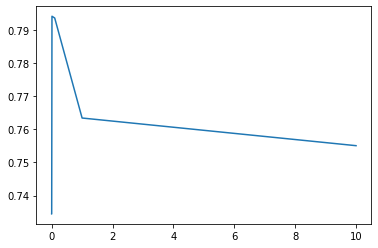

In [7]:
gamma_range=[0.0001,0.001,0.01,0.1,1,10]
accuracy=[]
for gamma_val in gamma_range:
    svc = svm.SVC(kernel='rbf', gamma=gamma_val)
    scores = cross_val_score(svc, train_x, train_y, cv=5, scoring='accuracy', n_jobs=-1)
    accuracy.append(scores.mean())
    
sns.lineplot(x=gamma_range,y=accuracy)

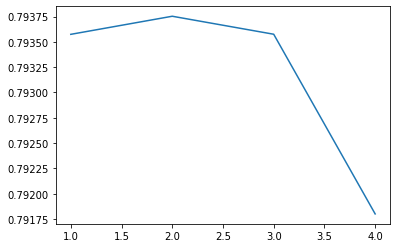

In [8]:
C_range=list(range(1,5))
accuracy=[]
for c in C_range:
    svc = svm.SVC(kernel='rbf', C=c)
    scores = cross_val_score(svc, train_x, train_y, cv=5, scoring='accuracy', n_jobs=-1)
    accuracy.append(scores.mean())
    
sns.lineplot(x=C_range,y=accuracy) 

In [15]:
tuned_parameters = {
# 'C':[0.5,1,2,3,4], 'kernel': ['linear'],
# 'C':[0.5,1,2,3,4], 'gamma': [0.0005,0.001,0.002, 0.004], 'kernel': ['rbf'],
 'degree': [1,2,3] ,'gamma': [0.0005,0.001,0.002, 0.004], 'C':[0.5,1,2,3,4], 'kernel':['poly']
                   }

GS = GridSearchCV(svm1, tuned_parameters,cv=5,scoring='accuracy',n_jobs=-1, verbose = True)
GS.fit(train_x,train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


[LibSVM]

GridSearchCV(cv=5, estimator=SVC(verbose=True), n_jobs=-1,
             param_grid={'C': [0.5, 1, 2, 3, 4], 'degree': [1, 2, 3],
                         'gamma': [0.0005, 0.001, 0.002, 0.004],
                         'kernel': ['poly']},
             scoring='accuracy', verbose=True)

In [16]:
print('The best parameters are :{}'.format(GS.best_params_))
print('The best score is: {}'.format(GS.best_score_))

The best parameters are :{'C': 4, 'degree': 1, 'gamma': 0.004, 'kernel': 'poly'}
The best score is: 0.7942859034107117


In [17]:
y_pred= GS.predict(test_x)

print(confusion_matrix(test_y, y_pred))
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
# print ("AUC Score:", roc_auc_score(test_y, y_pred))
# print ("AUC Score prob:", roc_auc_score(test_y, y_pred_prob))
# print ("Precision:", precision_score(test_y, y_pred))
# print ("Recall:", recall_score(test_y, y_pred))
print ("F1 Score:", f1_score(test_y, y_pred))

[[934 102]
 [152 221]]
Accuracy: 0.8197303051809794
F1 Score: 0.6350574712643677


In [ ]:
# Accuracy: 0.8218594748048261
# F1 Score: 0.6388489208633092